# 6. XP selection function

In [1]:
import os
import pathlib

import numpy as np
from scipy.special import expit, logit

from astroquery.gaia import Gaia
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord
import healpy as hp

import gaiaunlimited

import matplotlib.pyplot as plt

import config

hpx_order=7 --> (hpx_nside=128, hpx_npix=196608)


In [2]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Query subsample statistics

See examples at `docs/notebooks/SubsampleSF_Tutorial.ipynb` and `docs/notebooks/SubsampleSF_HMLE_Tutorial.ipynb`

In [3]:
Gaia.MAIN_GAIA_TABLE = 'gaiadr3.gaia_source'
inDict = {'healpix': config.hpx_order,
          'phot_g_mean_mag': [config.G_min, config.G_max, config.dG]}

In [4]:
# Store the collected data in the local directory
os.environ['GAIAUNLIMITED_DATADIR'] = str(cache_path)
# The queried table will be stored at cache_path/file_stem+'.csv'
file_stem = 'dr3_xp_stats'

In [ ]:
# The query is long, possibly need to login
Gaia.login()

In [5]:
%%time

# It takes ~50 mins from a fresh run
xp_stats \
    = gaiaunlimited.subsample.SubsampleSelectionFunctionHMLE(subsample_query='has_xp_continuous', \
                                                             file_name=file_stem, hplevel_and_binning=inDict, z=1.96)

Empty slice in phot_g_mean_mag, filling with nan


/home/kurbatov/GaiaUnlimited/2024 Hierarchical Selection/gaiaunlimited.git/src/gaiaunlimited/selectionfunctions/subsample.py:29: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ds.dims.keys() - set(["ipix"]) == {"g", "c"}:
/home/kurbatov/GaiaUnlimited/2024 Hierarchical Selection/gaiaunlimited.git/src/gaiaunlimited/selectionfunctions/subsample.py:32: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  diff = set(ds["logitp"].dims) - ds.dims.keys()


CPU times: user 39.5 s, sys: 3.59 s, total: 43 s
Wall time: 42.1 s


## Estimate the efficiency

In the Aurora application, we don't need the Binomial-conditioned MLE or the Hierarchical MLE.

In [6]:
# Hereinafter the Aurora model will use this pixelization level
hpx_order = config.model_hpx_order
hpx_nside = config.model_hpx_nside
hpx_npix = config.model_hpx_npix

ds = xp_stats.hds[hpx_order]
G = ds['phot_g_mean_mag_'].values
n = ds['n'].values
k = ds['k'].values

# Use simple MLE
denom = n.copy().astype(float)
denom[n == 0] = np.inf
prb_xp = k / denom
prb_xp_sky = np.nansum(k, axis=1) / np.nansum(n, axis=1)
#prb_xp_avg = prb_xp.mean(axis=0)

k_ = k.sum(axis=0)
n_ = n.sum(axis=0)
prb_xp_avg = np.where(n_ > 0, k_ / n_, 0.0)

/tmp/ipykernel_811394/3384576702.py:20: RuntimeWarning: invalid value encountered in divide
  prb_xp_avg = np.where(n_ > 0, k_ / n_, 0.0)


In [7]:
# Smooth the SF with Gaussian window

width = 2.0
window = sp.signal.windows.gaussian(G.size, std=width) / (np.sqrt(2*np.pi)*width)
prb_xp_smo = np.empty_like(prb_xp)
for hpx in range(hpx_npix):
    prb_xp_smo[hpx] = sp.signal.convolve(prb_xp[hpx], window, mode='same')

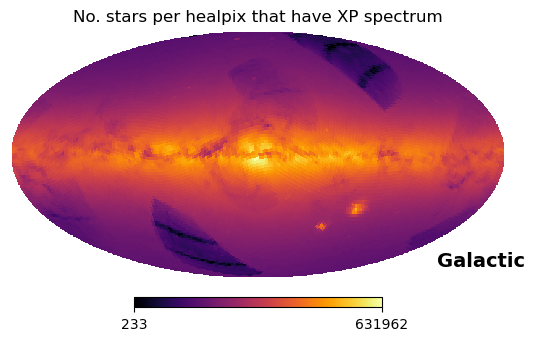

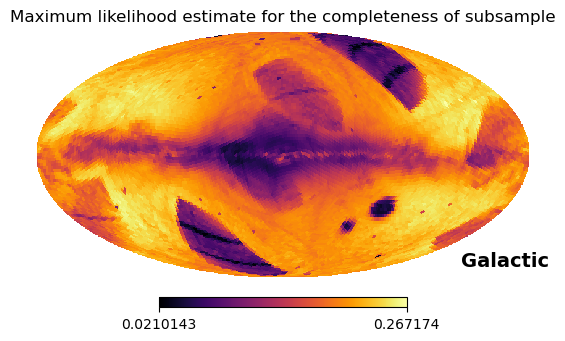

In [9]:
# Plot the sky maps off the `hds` list

# Collect the total number of sources inside every healpix, _regardless their magnitudes_ (the summation over the last axis is for that)
n_ = ds['n'].sum(axis=-1)
k_ = ds['k'].sum(axis=-1)

coords_of_centers = gaiaunlimited.utils.get_healpix_centers(hpx_order)

# We need to do this in order to harmonize the healpix enumeration scheme
ipix = gaiaunlimited.utils.coord2healpix(coords_of_centers, 'icrs', nside=hp.order2nside(hpx_order), nest=True)
n_ = n_[ipix]
k_ = k_[ipix]

plt.figure()
hp.mollview(k_, hold=True, norm='log', cmap='inferno', title="No. stars per healpix that have XP spectrum", coord='CG')
plt.show()
plt.close()

plt.figure()
hp.mollview(k_/n_, hold=True, cmap='inferno', title="Maximum likelihood estimate for the completeness of subsample", coord='CG')
plt.show()
plt.close()

ipix: [4807 1913]


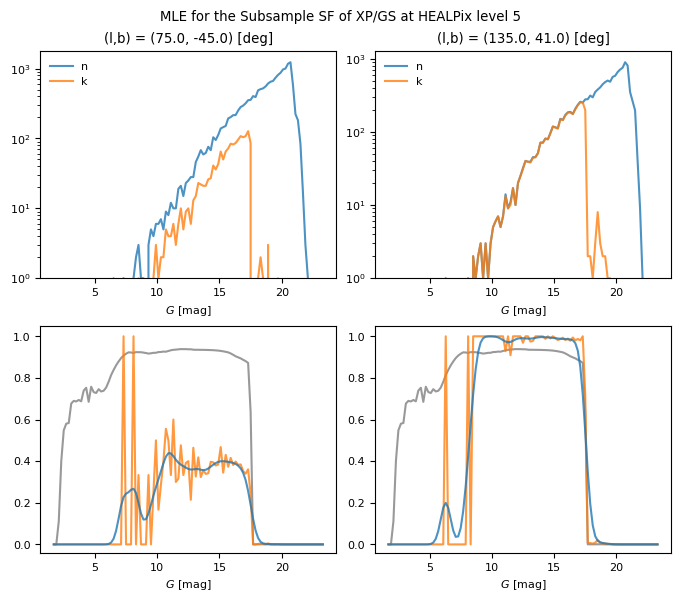

In [10]:
# Plot piercings along two directions
#
# NB: This is the simple MLE
#

plt.rc('font', size=8.0)
inch = 2.54  ## cm
width, height = 17/inch, 15/inch
plt.figure(figsize=(width, height), layout='constrained')
plt.suptitle(f"MLE for the Subsample SF of XP/GS at HEALPix level {hpx_order}")

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
alpha = 0.8

l = [ 75, 135]
b = [-45,  41]
co = SkyCoord(l, b, frame='galactic', unit='deg')
healpix = HEALPix(nside=hp.order2nside(hpx_order), order='nested', frame='icrs')
ipix = healpix.skycoord_to_healpix(co)
print("ipix:", ipix)

for i, hpx in enumerate(ipix):
    plt.subplot(2, 2, 1+i)
    plt.title(f"(l,b) = ({co[i].l.deg}, {co[i].b.deg}) [deg]")
    plt.plot(G, n[hpx], color=colors[0], alpha=alpha, label="n")
    plt.plot(G, k[hpx], color=colors[1], alpha=alpha, label="k")
    plt.legend(frameon=False)
    plt.xlabel("$G$ [mag]")
    plt.yscale('log')
    plt.ylim(ymin=1)

    plt.subplot(2, 2, 2+1+i)
    plt.plot(G, prb_xp_avg, color='grey', alpha=alpha)
    plt.plot(G, prb_xp[hpx], color=colors[1], alpha=alpha, label="MLE")
    plt.plot(G, prb_xp_smo[hpx], color=colors[0], alpha=alpha, label="Smoothed MLE")
    #plt.legend(frameon=False)
    plt.xlabel("$G$ [mag]")
    plt.ylim(ymin=-0.04)

plt.show()
plt.close()

# Save the XP selection function

In [11]:
d = {}
d['nside'] = hpx_nside
d['G_'] = config.G_bins
d['prb_xp'] = prb_xp
d['prb_xp_smo'] = prb_xp_smo
d['prb_xp_sky'] = prb_xp_sky
fpath = cache_path / f"sf_xp_hpx{hpx_order}_g.npz"
np.savez_compressed(fpath, **d)